## Chess EDA

(See Chess_Project_Introduction_Variable_Creation for our previously done work.)

In this module, we're interested in *getting a feel* for the variables in our dataset.

In [2]:
import pandas as pd
import numpy as np
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
games = pd.read_csv('games_new_vars.csv')

### Absolute value in differences
We'll start by checking out our abs_diff_rating variable. 

In [4]:
games.abs_diff_rating.describe()

count    20058.000000
mean       173.091435
std        179.214854
min          0.000000
25%         45.000000
50%        115.000000
75%        241.000000
max       1605.000000
Name: abs_diff_rating, dtype: float64

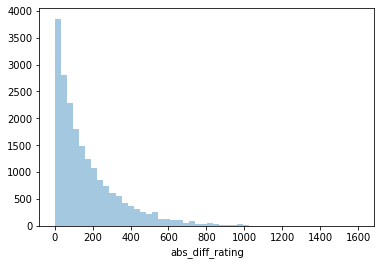

In [5]:
sns.distplot(games.abs_diff_rating,
                        kde=False)
plt.show()

We can see we've got a one tailed right skewed distribution of absolute values in rating. 

I wonder if we've got outliers hiding in here. 

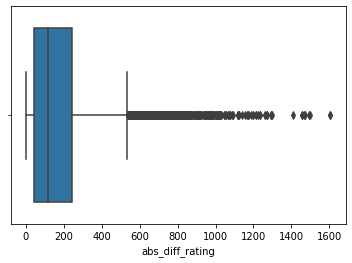

In [6]:
sns.boxplot(x="abs_diff_rating",
                data=games)
plt.show()

Definite yes. It looks like after the 580 absolute value difference, we have a load of upper outliers. However, we need not necessarily remove them since they could inform how large differences contribute to percentages of winning. Note that we don't have low outliers.

Let's find out how many of these upper outliers we have.

In [7]:
# Multiple definitions for an outlier exist. We use the boxplot definition inline with our plot above.
quartiles = np.percentile(games.abs_diff_rating, [25, 50, 75])
upper_cutoff = games.abs_diff_rating.mean() + 1.5 * ( quartiles[2] - quartiles[0] ) 

In [8]:
games.loc[games.abs_diff_rating > upper_cutoff, 'abs_diff_rating']

7        695
11       486
12       555
20       582
26       746
        ... 
19921    771
20012    768
20041    507
20042    494
20053    471
Name: abs_diff_rating, Length: 1491, dtype: int64

So, we have 1461 outliers. Here is our upper cutoff difference. 

In [9]:
np.round(upper_cutoff)

467.0

I'm curious. Do these big differences in rating have a high proportion of wins for the higher rated player? 

In [10]:
games.loc[games.abs_diff_rating > upper_cutoff, 'higher_rating_won'].value_counts()

1    1257
0     234
Name: higher_rating_won, dtype: int64

Recall that a value of 1 means the higher rated player won, 0 if they drew or lost. As a proportion, we have:

In [11]:
games.loc[games.abs_diff_rating > upper_cutoff, 'higher_rating_won'].value_counts(1)

1    0.843058
0    0.156942
Name: higher_rating_won, dtype: float64

Deciding to keep the outliers depends on the kind of model we use. So, we will leave the outliers alone.

### Victory status
We will now take a look at the frequency for victory status. 

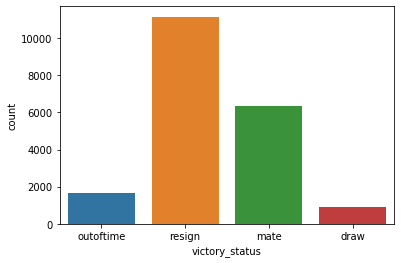

In [12]:
sns.countplot(x = 'victory_status', data = games)
plt.show()

Most players resigned before being submitted to the shame of a mate. Note how very little draws there are proportionate to the other results. 

When I've played online, I've sometimes beat a better player by having them run out of time. I wonder what we can say about the proportion of wins by a lower rated player due to running out of time. 

In [13]:
victory_higher_rating_g = games.victory_status.groupby(games.higher_rating_won)

In [14]:
victory_higher_rating_g.value_counts(1)

higher_rating_won  victory_status
0                  resign            0.516091
                   mate              0.276668
                   draw              0.117571
                   outoftime         0.089670
1                  resign            0.580473
                   mate              0.339459
                   outoftime         0.080068
Name: victory_status, dtype: float64

If we look at the proportions, the out of time proportion is only ever so slightly higher in the 0 category than in the 1 category. 
I don't think is big enough to make us believe a lower rated player wins more often from an out of time than a higher rated player. 

### Higher Rating Won

We are interested in checking out how often the higher rating won since this will be one of our response variables in our predictions. 

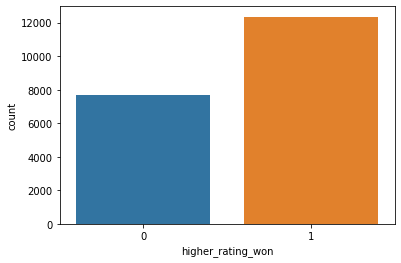

In [15]:
sns.countplot(x = 'higher_rating_won', data = games)
plt.show()

Most of the time, the higher rating won. Great. The rating system would probably need some tweaking if this wasn't the case.

### Number of turns

We can also check out the distribution for the number of turns taken. 

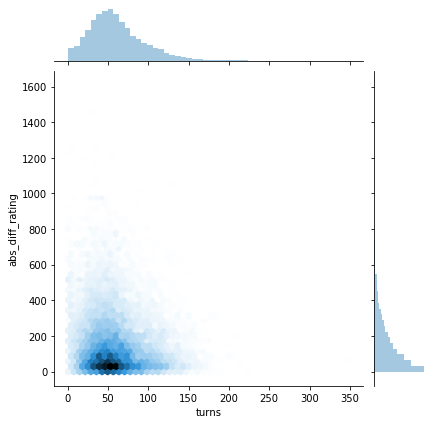

In [17]:
sns.jointplot(games.turns, 
              games.abs_diff_rating, 
              kind = 'hex')
plt.show()

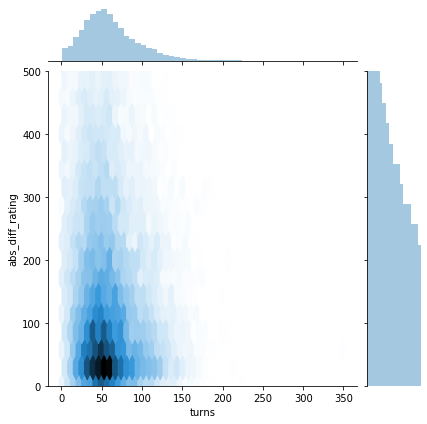

In [29]:
turns_abs = sns.jointplot(games.turns, 
              games.abs_diff_rating, 
              kind = 'hex')
#turns_abs.set(xlim=(0,1000), ylim=(0,150))
plt.xlim(0, 900)
plt.ylim(0,500)
plt.show()

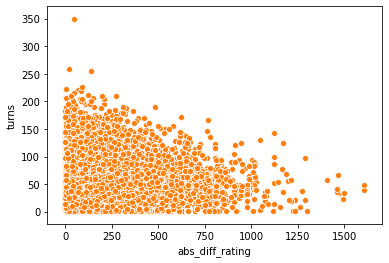

In [31]:
sns.scatterplot(games.abs_diff_rating, games.turns)
plt.show()

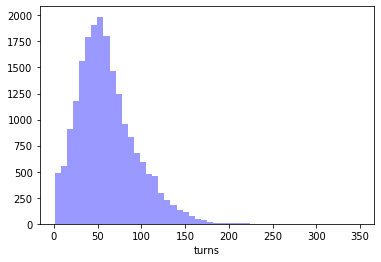

In [43]:
sns.distplot(games.turns, kde = False, color = 'b')
plt.show()

Looks like most turns hover around 50. Numerically, we can pinpoint the mean and median:

In [44]:
games.turns.describe()

count    20058.000000
mean        60.465999
std         33.570585
min          1.000000
25%         37.000000
50%         55.000000
75%         79.000000
max        349.000000
Name: turns, dtype: float64

We get a mean and a median that are similar at 60.46 (so 60 turns) and 55 respectively. Seeing 349 makes me curious. Who played that long a game? 

In [45]:
games.iloc[games.turns.max()]

Unnamed: 0                                                           349
id                                                              2icRDIZI
rated                                                               True
created_at                                                   1.50394e+12
last_move_at                                                 1.50394e+12
turns                                                                120
victory_status                                                      mate
winner                                                             black
increment_code                                                      10+0
white_id                                                        bomardan
white_rating                                                        1589
black_id                                                           tfeng
black_rating                                                        1569
moves                  d4 Nf6 c4 g6 Nc3 d5 Nf3 Bg7 

The players had similar ratings of 1589 (white) and 1569 (black). Cool that black won - I like it when the undergod makes it. And mated 'em too. 

Don't know if you saw this, Watson, but we had a min of 1 for turns (look out our output for numerical description of turn data). Big alert Houston! We'll have to address short turn games since these may affect our models. 

We'll start by checking out that game with one turn though.

In [50]:
games.iloc[games.turns.idxmin()]

Unnamed: 0                          1946
id                              3K5kYPO8
rated                               True
created_at                   1.49153e+12
last_move_at                 1.49153e+12
turns                                  1
victory_status                    resign
winner                             black
increment_code                      10+0
white_id                    serik-astana
white_rating                        1464
black_id                      brorael357
black_rating                        1355
moves                                 g3
opening_eco                          A00
opening_name           Hungarian Opening
opening_ply                            1
diff_rating                          109
abs_diff_rating                      109
higher_rating                      white
higher_rating_won                      0
higher_rating_coded                    1
white_higher_rated                     1
result                                 0
Name: 1946, dtyp

Of course, this kind of game could disrupt our model work later so we intend to remove it. For now, note how many games took less than 10 turns. 

In [53]:
len(games.loc[games.turns < 10])

617

### Result 

Finally, let's look at the result variable. 

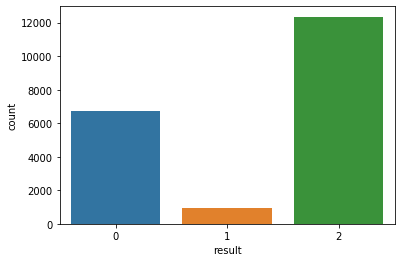

In [35]:
sns.countplot(x = 'result', data = games)
plt.show()

This reflects our victory status variable. For the higher rated player, we have mostly wins (2), a little more than half of these are losses (0), and a small proportion turn out to be draws (1). Numerically, we have that:

In [43]:
games.result.value_counts(1)

2    0.615814
0    0.336823
1    0.047363
Name: result, dtype: float64

### Increment code 
You have noticed a variable called increment code. 

In [36]:
games.increment_code

0         15+2
1         5+10
2         5+10
3         20+0
4         30+3
         ...  
20053    10+10
20054     10+0
20055     10+0
20056     10+0
20057     10+0
Name: increment_code, Length: 20058, dtype: object

This variable gives us how much each player will receive in rating increase. Intuitively, if a high rated player beats a lower rated player, the higher rated player would receive a few points. But, if the lower rated player beat the higher rated player, they would probably receive a higher amount of points. A draw would result in players receiving the same increment. 

I sound like an expert in this variable, but I'm not. It's my guess. Let's see if my guess holds. To do so, we will check drawed games and see if the increment is equal. 

In [40]:
games.loc[games.victory_status == 'draw', 'increment_code']

5         10+0
40       20+25
98        15+0
126      15+15
143      15+15
         ...  
20003    30+30
20004    30+30
20011    45+45
20014    45+45
20034    45+45
Name: increment_code, Length: 906, dtype: object

So the increment isn't always equal. But this makes sense since a lower rated player could draw with a higher rated player and deserve to be elevated. 

A potential rabbit hole for us to jump is figuring out how an increment code is determined based on result and difference in rating. But we'll leave that for another bedtime story. 

### Conclusions

1) We need not worry about low outliers in the absolute value of differences between ratings. High outliers, however, do exist (according to our definition of boxplot outliers), and we will deal with them based on the model we apply to the data. 

2) For the higher rated player, most of the games end up as wins ~61%, then losses ~37% with a majority of resignations, instead of checkmates. A small percentage are draws ~5%. 

3) The turns variable reveal that we may need to remove short turn games since they offer little information. 

4) An interesting study would be to determine how increment codes are decided. 

